In [29]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

# import seaborn as sns

# from keras import Model
# from keras import regularizers
# from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from keras.optimizers import Adam, RMSprop, SGD
# from keras.models import Sequential
# from keras.layers.normalization import BatchNormalization
# from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, Input, AveragePooling2D, Activation
# from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

from tqdm import notebook
from os import listdir, path
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
size = (200,200)
dataset_path = 'chest_xray/chest_xray'

In [4]:
def read_imgs(directory):
    X = []
    y = []
    
    for folder in listdir(directory):
        imgs_path = path.join(directory, folder)

        if folder == 'NORMAL':
            target = 0
        elif folder == 'PNEUMONIA':
            target = 1
        else:
          continue

        print("Processing " + imgs_path + " images")
        for img_path in notebook.tqdm(listdir(imgs_path)):
            if '.jpeg' in img_path:
              img = cv2.imread(path.join(imgs_path, img_path))
              img = cv2.resize(img, size)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
              X.append(img)
              y.append(target)

    X = np.array(X)
    y = np.array(y)
    
    return X, y   

In [7]:
!unzip 'gdrive/My Drive/chest_xray.zip'

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [16]:
train_directory = path.join(dataset_path, 'train')
test_directory = path.join(dataset_path, 'test')
val_directory = path.join(dataset_path, 'val')

X_train, y_train = read_imgs(train_directory)
X_test, y_test = read_imgs(test_directory)
X_val, y_val = read_imgs(val_directory)

Processing chest_xray/chest_xray/train/NORMAL images



Processing chest_xray/chest_xray/train/PNEUMONIA images



Processing chest_xray/chest_xray/test/NORMAL images



Processing chest_xray/chest_xray/test/PNEUMONIA images



Processing chest_xray/chest_xray/val/NORMAL images



Processing chest_xray/chest_xray/val/PNEUMONIA images


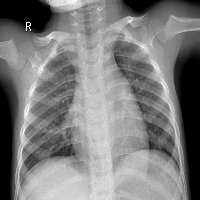

In [17]:
cv2_imshow(X_train[0])

In [20]:
# Shuffle data
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_val, y_val = shuffle(X_val, y_val)

In [21]:
X_train = X_train.reshape((-1, 200, 200, 1))
X_test = X_test.reshape((-1, 200, 200, 1))
X_val = X_val.reshape((-1, 200, 200, 1))

print("X_train shape: ", X_train.shape)
print("X_test shape: ,", X_test.shape)
print("X_val shape: ,", X_val.shape)

X_train shape:  (5216, 200, 200, 1)
X_test shape: , (624, 200, 200, 1)
X_val shape: , (16, 200, 200, 1)


In [22]:
# Add more images to validation set from training set

X_train, X_val2, y_train, y_val2 = train_test_split(X_train, y_train, test_size=0.12)
X_val = np.append(X_val, X_val2, axis=0)
y_val = np.append(y_val, y_val2, axis=0)
print("X_val shape: ", X_val.shape)


X_val shape:  (642, 200, 200, 1)


{0: 0.2581699346405229, 1: 0.7418300653594772}


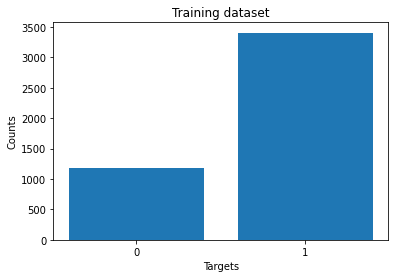

In [23]:
targets, count = np.unique(y_train, return_counts=True)

class_weight={0:count[0]/X_train.shape[0], 1:count[1]/X_train.shape[0]}
print(class_weight)

plt.title("Training dataset")
plt.bar(targets, count, tick_label=targets)
plt.xlabel("Targets")
plt.ylabel("Counts")
plt.show()

{0: 0.375, 1: 0.625}


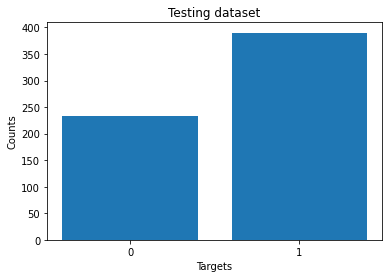

In [24]:
targets, count = np.unique(y_test, return_counts=True)
print({0:count[0]/X_test.shape[0], 1:count[1]/X_test.shape[0]})

plt.title("Testing dataset")
plt.bar(targets, count, tick_label=targets)
plt.xlabel("Targets")
plt.ylabel("Counts")
plt.show()

{0: 0.2554517133956386, 1: 0.7445482866043613}


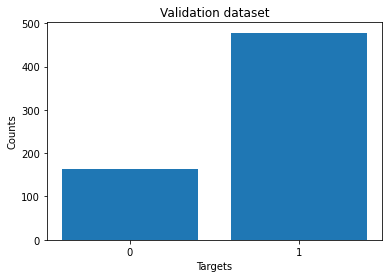

In [25]:
targets, count = np.unique(y_val, return_counts=True)
print({0:count[0]/X_val.shape[0], 1:count[1]/X_val.shape[0]})

plt.title("Validation dataset")
plt.bar(targets, count, tick_label=targets)
plt.xlabel("Targets")
plt.ylabel("Counts")
plt.show()

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
  
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(4590, 6084)


In [31]:
#Training
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
#Test
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

In [33]:
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[ True  True  True  True  True  True False  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  71.47435897435898


In [34]:
from sklearn.metrics import confusion_matrix
 
label_names = ['pneumonia', 'healthy']
cmx = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cmx, columns=label_names, index=label_names)
df.columns.name = 'prediction'
df.index.name = 'label'
df

prediction,pneumonia,healthy
label,,
pneumonia,58,176
healthy,2,388


In [35]:
cmx = confusion_matrix(y_test, y_pred)


 [0, 1]


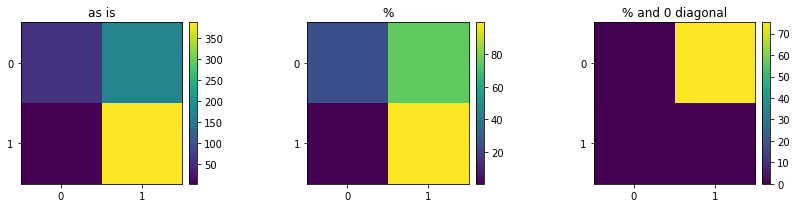

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

In [ ]:
datagen_train = ImageDataGenerator(
  rescale=1./255,
  width_shift_range=0.1,
  height_shift_range=0.1,
  rotation_range=10,  
  zoom_range = 0.1, 
)

datagen_test = ImageDataGenerator(
  rescale=1./255
)

batch_size = 64
train_iterator = datagen_train.flow(X_train, y_train, batch_size=batch_size)
val_iterator = datagen_test.flow(X_val, y_val)

In [ ]:
X_test = X_test/255